# 实验四：基于Auto-Encoder的图像压缩实验


## 实验介绍

降维是一种对高维度特征数据预处理方法。降维是将高维度的数据保留下最重要的一些特征，去除噪声和不重要的特征，从而实现提升数据处理速度的目的。在实际的生产和应用中，降维在一定的信息损失范围内，可以为我们节省大量的时间和成本。降维也成为应用非常广泛的数据预处理方法。本实验主要介绍使用MindSpore在图像数据集上使用PCA和Auto-Encoder模型进行图像压缩实验。

## 实验目的

- 了解降维算法和PCA的基本概念；
- 了解auto-encoder模型的用途与搭建方法

## 实验环境

- MindSpore 1.7.0

In [1]:
%cd /home/ma-user/work

/home/ma-user/work


In [2]:
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/MNIST.zip
!unzip MNIST.zip

--2025-12-19 14:18:41--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/MNIST.zip
Resolving ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)... 100.125.83.133, 100.125.76.5, 100.125.83.5
Connecting to ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)|100.125.83.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11684046 (11M) [application/zip]
Saving to: ‘MNIST.zip’

MNIST.zip           100%[===================>]  11.14M  --.-KB/s    in 0.1s    

2025-12-19 14:18:41 (92.6 MB/s) - ‘MNIST.zip’ saved [11684046/11684046]

Archive:  MNIST.zip
   creating: MNIST/test/
  inflating: MNIST/test/t10k-images-idx3-ubyte  
  inflating: MNIST/test/t10k-labels-idx1-ubyte  
   creating: MNIST/train/
  inflating: MNIST/train/train-images-idx3-ubyte  
  inflating: MNIST/train/train-lab

## 实验内容

### 实验原理

PCA（Principal Component Analysis）是一种使用最广泛的数据降维算法，常用于高维数据的降维，可用于提取数据的主要特征分量。其主要思想是将n维特征映射到k维上，这k维是全新的正交特征也被称为主成分，是在原有n维特征的基础上重新构造出来的k维特征。其算法步骤如下：

设有 m 条 n 维数据。

1. 将原始数据按列组成 n 行 m 列矩阵 X；
2. 将 X 的每一行进行零均值化，即减去这一行的均值；
3. 求出协方差矩阵 $C=\frac{1}{m}XX^T$ ；
4. 求出协方差矩阵的特征值及对应的特征向量；
5. 将特征向量按对应特征值大小从上到下按行排列成矩阵，取前 k 行组成矩阵 P；
6. $Y=PX$即为降维到 k 维后的数据。

自编码器（AutoEncoder）是一种用于无监督学习的神经网络模型，它的基本原理可以概括为以下几个步骤：

1. 编码器（Encoder）：这部分的网络将输入数据压缩成一个较低维度的表示形式（称为编码）。这个过程类似于数据压缩，目的是提取输入数据中最重要的特征
2. 编码（Code）：编码是编码器处理后的结果，它是输入数据的一个压缩表示。编码通常是一个远小于输入数据维度的向量，它捕捉了输入数据的核心特征
3. 解码器（Decoder）：解码器部分尝试从编码中重构原始输入数据。这个过程可以看作是对编码的解压缩。理想情况下，解码器的输出应该与原始输入数据尽可能相似
4. 损失函数（Loss Function）：自编码器的训练过程中，需要一个损失函数来度量解码器输出和原始输入之间的差异。常用的损失函数包括均方误差（MSE）等。通过最小化这个损失，网络学习到如何有效地编码和解码数据。

### 导入模块包并初始化环境

In [3]:
import os
import numpy as np
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
import mindspore.ops as ops
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from mindspore import Tensor, Model, nn, context
from mindspore.train.serialization import load_checkpoint
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor

context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU")

In [4]:
cfg = edict({
    'channel': 1,  # 图片通道数
    'image_height': 32,  # 图片高度
    'image_width': 32,  # 图片宽度
    'batch_size': 128,
    'embed_size': 30,
    'data_dir': 'MNIST'
})

### 可视化

In [5]:
def visualize(images, labels):
    plt.figure(figsize=(10, 3))
    for (i, img) in enumerate(images):
        if img.ndim == 2:
            img = np.expand_dims(img, axis=2)
        else:
            img = img.transpose(1, 2, 0)
        plt.subplot(1, 8, i+1)
        plt.imshow((img*255).astype(int), cmap='gray')
        plt.title('%s' % labels[i])
        plt.xticks([])
    plt.show()

### 构建数据集

In [6]:
def create_dataset(data_dir=cfg.data_dir, training=True, batch_size=6, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    data_train = os.path.join(data_dir, 'train') # 训练集信息
    data_test = os.path.join(data_dir, 'test') # 测试集信息
    ds = ms.dataset.MnistDataset(data_train if training else data_test)

    ds = ds.map(input_columns=["image"], operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns=["label"], operations=C.TypeCast(ms.int32))
    # When `dataset_sink_mode=True` on Ascend, append `ds = ds.repeat(num_epochs) to the end
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

    return ds

### PCA


In [7]:
#数据中心化
def Z_centered(dataMat):
	rows,cols=dataMat.shape
	meanVal = np.mean(dataMat, axis=0)  # 按列求均值，即求各个特征的均值
	meanVal = np.tile(meanVal,(rows,1))
	newdata = dataMat-meanVal
	return newdata, meanVal
 
#协方差矩阵
def Cov(dataMat):
	rows = dataMat.shape[0]
	meanVal = np.mean(dataMat,0) #压缩行，返回1*cols矩阵，对各列求均值
	meanVal = np.tile(meanVal, (rows,1)) #返回rows行的均值矩阵
	Z = dataMat - meanVal
	Zcov = (1/(rows-1))*Z.T * Z
	return Zcov
	
#得到最大的k个特征值和特征向量
def EigDV(covMat, k):
	D, V = np.linalg.eig(covMat) # 得到特征值和特征向量
	eigenvalue = np.argsort(D)
	K_eigenValue = eigenvalue[-1:-(k+1):-1]
	K_eigenVector = V[:,K_eigenValue]
	return K_eigenValue, K_eigenVector
	
#得到降维后的数据
def getlowDataMat(DataMat, K_eigenVector):
	return DataMat * K_eigenVector
 
#重构数据
def Reconstruction(lowDataMat, K_eigenVector, meanVal):
	reconDataMat = lowDataMat * K_eigenVector.T + meanVal
	return reconDataMat
 
#PCA算法
def PCA(data, k):
	dataMat = np.float32(np.mat(data))
	#数据中心化
	dataMat, meanVal = Z_centered(dataMat)
	#计算协方差矩阵
	covMat = np.cov(dataMat, rowvar=0)
	#得到最大的k个特征值和特征向量
	_, V = EigDV(covMat, k)
	#得到降维后的数据
	lowDataMat = getlowDataMat(dataMat, V)
	#重构数据
	reconDataMat = Reconstruction(lowDataMat, V, meanVal)
	return lowDataMat, reconDataMat

[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-14:21:25.972.35 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-14:21:25.995.11 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-14:21:25.100.456 [mindspore/dataset/core/validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-14:21:25.101.618 [mindspore/dataset/c

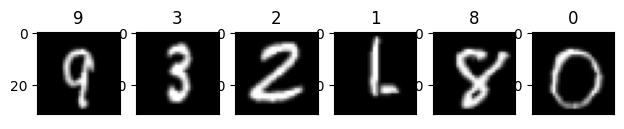

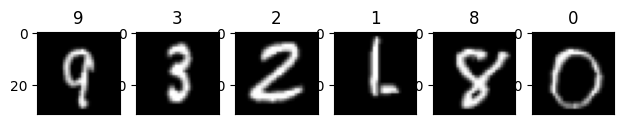

In [8]:
val_ds = create_dataset(training=False, resize=(cfg.image_height, cfg.image_width))
data = val_ds.create_dict_iterator().__next__()
oriImage = data['image']
labels = data['label']

images = oriImage.asnumpy().reshape(6, -1)

_, reconImages = PCA(images, cfg.embed_size)

reconImages = reconImages.A.astype(np.float64).reshape((6, 1, cfg.image_height, cfg.image_width))

# 可视化
visualize(oriImage.asnumpy(), labels.asnumpy())
visualize(reconImages, labels.asnumpy())

### Auto-Encoder

In [9]:
# 定义CNN图像识别网络
class AutoEncoder_Net(nn.Cell):
    def __init__(self, in_channel, embeded_channel=2):
        super(AutoEncoder_Net, self).__init__()
        self.encoder = nn.SequentialCell([
            nn.Dense(in_channel, 400),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(400, embeded_channel),
            nn.ReLU()
        ])
        self.decoder = nn.SequentialCell([
            nn.Dense(embeded_channel, 400),
            nn.ReLU(),
            nn.Dense(400, in_channel),
            nn.Sigmoid(),
        ])
        self.flatten = nn.Flatten()
    #构建模型
    def construct(self, x):
        x = self.flatten(x)
        lowData = self.encoder(x)
        reconData = self.decoder(lowData)
        return x, lowData, reconData

In [43]:
# 定义CNN图像识别网络
class AutoEncoder_Net(nn.Cell):
    def __init__(self, in_channel, embeded_channel=2):
        super(AutoEncoder_Net, self).__init__()
        self.encoder = nn.SequentialCell([
            nn.Dense(in_channel, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(512, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(128, embeded_channel),
            nn.ReLU()
        ])
        self.decoder = nn.SequentialCell([
            nn.Dense(embeded_channel, 128),
            nn.ReLU(),
            nn.Dense(128, 512),
            nn.ReLU(),
            nn.Dense(512, in_channel),
            nn.Sigmoid(),
        ])
        self.flatten = nn.Flatten()
    #构建模型
    def construct(self, x):
        x = self.flatten(x)
        lowData = self.encoder(x)
        reconData = self.decoder(lowData)
        return x, lowData, reconData

In [29]:
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops

class ConvAutoEncoder(nn.Cell):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.enc = nn.SequentialCell([
            nn.Conv2d(1, 32, kernel_size=3, stride=2, pad_mode='pad', padding=1),  # 28->14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, pad_mode='pad', padding=1), # 14->7
            nn.ReLU(),
        ])


        self.reshape = ops.Reshape()

        self.dec = nn.SequentialCell([
            nn.Conv2dTranspose(64, 32, kernel_size=3, stride=2, pad_mode='pad', padding=1, output_padding=1), # 7->14
            nn.ReLU(),
            nn.Conv2dTranspose(32, 1, kernel_size=3, stride=2, pad_mode='pad', padding=1, output_padding=1),  # 14->28
            nn.Sigmoid()
        ])

    def construct(self, x):
        z = self.enc(x)                     # (N, embed_dim)
        recon = self.dec(z)                 # (N, 1, 28, 28)
        return x, z, recon



In [47]:
import mindspore.nn as nn
import mindspore.ops as ops

class ConvAutoEncoder(nn.Cell):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.enc = nn.SequentialCell([
            nn.Conv2d(1, 32, 3, stride=2, pad_mode='pad', padding=1),   # 28->14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, pad_mode='pad', padding=1),  # 14->7
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dense(64 * 8 * 8, embed_dim),  # latent 向量
        ])

        self.fc = nn.SequentialCell([
            nn.Dense(embed_dim, 64 * 8 * 8),
            nn.ReLU(),
        ])

        self.reshape = ops.Reshape()

        self.dec = nn.SequentialCell([
            nn.Conv2dTranspose(64, 32, 3, stride=2, pad_mode='pad', padding=1, output_padding=1),  # 7->14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2dTranspose(32, 1, 3, stride=2, pad_mode='pad', padding=1, output_padding=1),   # 14->28
            nn.Sigmoid(),
        ])

    def construct(self, x):
        z = self.enc(x)                                # (N, embed_dim)
        h = self.fc(z)                                 # (N, 64*7*7)
        h = self.reshape(h, (-1, 64, 8, 8))            # (N, 64, 7, 7)
        recon = self.dec(h)                            # (N, 1, 28, 28)
        return x, z, recon


In [11]:
class vaeLoss(nn.loss.loss.LossBase):
    def __init__(self):
        super(vaeLoss, self).__init__()
        self.zeros = ops.ZerosLike()
        self.mse = nn.MSELoss(reduction='mean')

    def construct(self, data, label):
        oriData, _, reconData = data
        return self.mse(oriData, reconData)

In [36]:
# 删除原始保存的模型参数
!rm -f ./exp/auto_encoder-20_468.ckpt

train_ds = create_dataset('MNIST', training=True, batch_size=cfg.batch_size, resize=(cfg.image_height, cfg.image_width))

net=AutoEncoder_Net(in_channel=cfg.image_height*cfg.image_width, embeded_channel=cfg.embed_size)
#net=ConvAutoEncoder()
net_loss=vaeLoss()
optimizer=nn.Adam(net.trainable_params(), 0.001)

model = Model(net, loss_fn=net_loss, optimizer=optimizer)
loss_cb = LossMonitor(per_print_times=100)
config_ck = CheckpointConfig(save_checkpoint_steps=100,
                             keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix='auto_encoder', directory='./exp/', config=config_ck)
print("============== Starting Training ==============")
model.train(5, train_ds, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=False)
print("============== finish Training ==============")


[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:17:46.355.119 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:17:46.356.446 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:17:46.357.361 [mindspore/dataset/core/validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:17:46.358.938 [mindspore/dataset

============== Starting Training ==============
epoch: 1 step: 100, loss is 0.05746453255414963
epoch: 1 step: 200, loss is 0.054971083998680115
epoch: 1 step: 300, loss is 0.051452863961458206
epoch: 1 step: 400, loss is 0.051889922469854355
epoch: 2 step: 32, loss is 0.04882465675473213
epoch: 2 step: 132, loss is 0.054144397377967834
epoch: 2 step: 232, loss is 0.047542162239551544
epoch: 2 step: 332, loss is 0.050186581909656525
epoch: 2 step: 432, loss is 0.044663120061159134
epoch: 3 step: 64, loss is 0.045329395681619644
epoch: 3 step: 164, loss is 0.043416816741228104
epoch: 3 step: 264, loss is 0.042586278170347214
epoch: 3 step: 364, loss is 0.04215162992477417
epoch: 3 step: 464, loss is 0.040086254477500916
epoch: 4 step: 96, loss is 0.04043420031666756
epoch: 4 step: 196, loss is 0.03174405172467232
epoch: 4 step: 296, loss is 0.03315538913011551
epoch: 4 step: 396, loss is 0.03167092055082321
epoch: 5 step: 28, loss is 0.031043069437146187
epoch: 5 step: 128, loss is 0.03

[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:10:16.235.25 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:10:16.248.79 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:10:16.257.33 [mindspore/dataset/core/validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(7208:140603970070336,MainProcess):2025-12-19-15:10:16.266.26 [mindspore/dataset/cor

============== Starting Training ==============
epoch: 1 step: 100, loss is 0.04862464591860771
[step 100] loss=0.048625
epoch: 1 step: 200, loss is 0.03868306428194046
[step 200] loss=0.038683
epoch: 1 step: 300, loss is 0.0382390171289444
[step 300] loss=0.038239
epoch: 1 step: 400, loss is 0.03604133799672127
[step 400] loss=0.036041
epoch: 2 step: 32, loss is 0.0276606697589159
[step 500] loss=0.027661
epoch: 2 step: 132, loss is 0.02208772301673889
[step 600] loss=0.022088
epoch: 2 step: 232, loss is 0.02035812847316265
[step 700] loss=0.020358
epoch: 2 step: 332, loss is 0.020138826221227646
[step 800] loss=0.020139
epoch: 2 step: 432, loss is 0.019220814108848572
[step 900] loss=0.019221
epoch: 3 step: 64, loss is 0.0188092440366745
[step 1000] loss=0.018809
epoch: 3 step: 164, loss is 0.01916787400841713
[step 1100] loss=0.019168
epoch: 3 step: 264, loss is 0.018641114234924316
[step 1200] loss=0.018641
epoch: 3 step: 364, loss is 0.018954040482640266
[step 1300] loss=0.018954


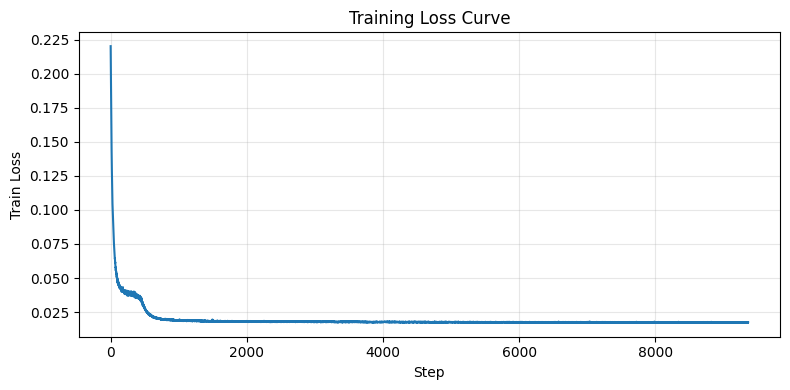

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.train.callback import Callback, LossMonitor, CheckpointConfig, ModelCheckpoint

class LossHistory(Callback):
    def __init__(self, per_print_times=100):
        super().__init__()
        self.losses = []
        self.steps = []
        self.per_print_times = per_print_times

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        # net_outputs 可能是 Tensor / tuple(Tensor, ...)
        if isinstance(loss, (tuple, list)):
            loss = loss[0]
        if hasattr(loss, "asnumpy"):
            loss = float(loss.asnumpy())
        else:
            loss = float(loss)

        step = int(cb_params.cur_step_num)
        self.losses.append(loss)
        self.steps.append(step)

        if self.per_print_times and step % self.per_print_times == 0:
            print(f"[step {step}] loss={loss:.6f}")

# ===== 你的训练代码 =====
!rm -f ./exp/auto_encoder-5_468.ckpt

train_ds = create_dataset(
    'MNIST', training=True, batch_size=cfg.batch_size,
    resize=(cfg.image_height, cfg.image_width)
)

net = AutoEncoder_Net(in_channel=cfg.image_height * cfg.image_width,
                      embeded_channel=cfg.embed_size)
net = ConvAutoEncoder()
#net_loss = vaeLoss()
optimizer = nn.Adam(net.trainable_params(), 0.001)

model = Model(net, loss_fn=net_loss, optimizer=optimizer)

loss_cb = LossMonitor(per_print_times=100)
loss_hist_cb = LossHistory(per_print_times=100)

config_ck = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix='auto_encoder', directory='./exp/', config=config_ck)

print("============== Starting Training ==============")
model.train(20, train_ds,
            callbacks=[loss_cb, loss_hist_cb, ckpoint_cb],
            dataset_sink_mode=False)  # 记录 step loss 建议保持 False
print("============== finish Training ==============")

# ===== 画 loss 曲线 =====
plt.figure(figsize=(8, 4))
plt.plot(loss_hist_cb.steps, loss_hist_cb.losses)
plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 可选：保存图片
# plt.savefig("./exp/train_loss_curve.png", dpi=200)


### 验证

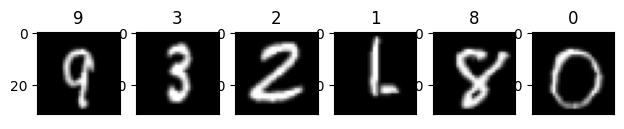

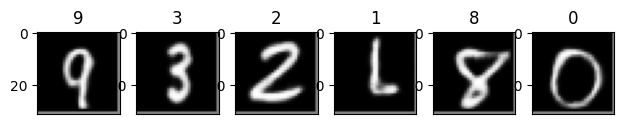

In [49]:
CKPT = './exp/auto_encoder_5-20_468.ckpt'
#eval_net = AutoEncoder_Net(in_channel=cfg.image_height*cfg.image_width, embeded_channel=cfg.embed_size)
eval_net = ConvAutoEncoder()
load_checkpoint(CKPT, net=eval_net)
eval_net.set_train(False)

_, _, reconImg = eval_net(oriImage)

# 可视化原图
visualize(oriImage.asnumpy(), labels.asnumpy())

# 可视化压缩后复原
reconImg = reconImg.view(6, cfg.image_height, cfg.image_width)
visualize(reconImg.asnumpy(), labels.asnumpy())

## 实验结果与分析（15'）

### 任务一（5'）

实现PCA对图像的压缩，在实验报告上粘贴得到的部分图像结果

### 任务二（10'）

运行Auto-Encoder baseline，在实验报告上粘贴得到的部分图像结果，比较分别使用PCA和auto-encoder压缩并复原后的图像效果（Auto-encoder效果不一定比PCA好，有时间可以好好调调），进行一定的分析。
